# Preprocessing the data of scRNA-seq with omicverse

The count table, a numeric matrix of genes × cells, is the basic input data structure in the analysis of single-cell RNA-sequencing data. A common preprocessing step is to adjust the counts for variable sampling efficiency and to transform them so that the variance is similar across the dynamic range. 

Suitable methods to preprocess the scRNA-seq is important. Here, we introduce some preprocessing step to help researchers can perform downstream analysis easyier.

User can compare our tutorial with [scanpy'tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) to learn how to use omicverse well

Colab_Reproducibility：https://colab.research.google.com/drive/1DXLSls_ppgJmAaZTUvqazNC_E7EDCxUe?usp=sharing

In [ ]:
import scanpy as sc
import omicverse as ov
ov.plot_set()


The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [ ]:
# !mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [2]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

## Preprocessing

### Quantity control

For single-cell data, we require quality control prior to analysis, including the removal of cells containing double cells, low-expressing cells, and low-expressing genes. In addition to this, we need to filter based on mitochondrial gene ratios, number of transcripts, number of genes expressed per cell, cellular Complexity, etc. For a detailed description of the different QCs please see the document: https://hbctraining.github.io/scRNA-seq/lessons/04_SC_quality_control.html

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    if the version of `omicverse` larger than `1.6.4`, the `doublets_method` can be set between `scrublet` and `sccomposite`.
  </p>
</div>

COMPOSITE (COMpound POiSson multIplet deTEction model) is a computational tool for multiplet detection in both single-cell single-omics and multiomics settings. It has been implemented as an automated pipeline and is available as both a cloud-based application with a user-friendly interface and a Python package.

Hu, H., Wang, X., Feng, S. et al. A unified model-based framework for doublet or multiplet detection in single-cell multiomics data. Nat Commun 15, 5562 (2024). https://doi.org/10.1038/s41467-024-49448-x

In [4]:
%%time
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
               doublets_method='sccomposite',
              batch_key=None)
adata

CPU mode activated
Calculate QC metrics
End calculation of QC metrics.
Original cell number: 2700
!!!It should be noted that the `sccomposite` will remove more cells than             `scrublet`!!!
Begin of post doublets removal and QC plot using `sccomposite`
Cuda is available; Fitting the COMPOSITE model on the RNA modality
Found 1 GPUs available. Using GPU 0         (NVIDIA GeForce RTX 2080 Ti) of compute capability 7.        5 with 11.5Gb total memory.

The RNA modality goodness-of-fit score is: 4.268524182045417 
<3: poor fit 
3~5: moderate fit 
>5: good fit
Cells retained after sccomposite: 2516, 184 removed.
End of post sccomposite removal and QC plots.
Filters application (seurat or mads)
Lower treshold, nUMIs: 500; filtered-out-cells:         0
Lower treshold, n genes: 250; filtered-out-cells:         3
Lower treshold, mito %: 0.2; filtered-out-cells:         2
Filters applicated.
Total cell filtered out with this last --mode seurat QC (and its     chosen options): 5
Cells reta

AnnData object with n_obs × n_vars = 2511 × 13355
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells'

### High variable Gene Detection

Here we try to use Pearson's method to calculate highly variable genes. This is the method that is proposed to be superior to ordinary normalisation. See [Article](https://www.nature.com/articles/s41592-023-01814-1#MOESM3) in *Nature Method* for details.


normalize|HVGs：We use | to control the preprocessing step, | before for the normalisation step, either `shiftlog` or `pearson`, and | after for the highly variable gene calculation step, either `pearson` or `seurat`. Our default is `shiftlog|pearson`.

- if you use `mode`=`shiftlog|pearson` you need to set `target_sum=50*1e4`, more people like to se `target_sum=1e4`, we test the result think 50*1e4 will be better
- if you use `mode`=`pearson|pearson`, you don't need to set `target_sum`

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    if the version of `omicverse` lower than `1.4.13`, the mode can only be set between `scanpy` and `pearson`.
  </p>
</div>


In [5]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,
                       target_sum=50*1e4)
adata

Begin robust gene identification
After filtration, 13355/13355 genes are kept.     Among 13355 genes, 13355 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 1.092604637145996 seconds.
End of size normalization: shiftlog and HVGs selection pearson
CPU times: user 1.61 s, sys: 80.3 ms, total: 1.69 s
Wall time: 1.11 s


AnnData object with n_obs × n_vars = 2511 × 13355
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts'

You can use `recover_counts` to recover the raw counts after normalize and log1p

In [10]:
adata[:,'CD3D'].to_df().T

,AAACATACAACCAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,AAACTTGATCCAGA-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
CD3D,6.718757,7.371373,0.0,0.0,5.447429,6.133358,6.499361,5.974209,0.0,6.039684,...,0.0,0.0,0.0,6.532146,0.0,0.0,0.0,0.0,0.0,6.224622


In [14]:
adata[:,'CD3D'].to_df(layer='counts').T

,AAACATACAACCAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,AAACTTGATCCAGA-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
CD3D,4.0,10.0,0.0,0.0,1.0,2.0,3.0,1.0,0.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0


In [15]:
X_counts_recovered, size_factors_sub=ov.pp.recover_counts(adata.X, 50*1e4, 50*1e5, log_base=None, 
                                                          chunk_size=10000)
adata.layers['recover_counts']=X_counts_recovered
adata[:,'CD3D'].to_df(layer='recover_counts').T

100%|██████████| 2511/2511 [00:02<00:00, 1127.63it/s]


,AAACATACAACCAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,AAACTTGATCCAGA-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
CD3D,4,9,0,0,1,1,2,1,0,2,...,0,0,0,2,0,0,0,0,0,1


Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [6]:
%%time
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

CPU times: user 4.75 ms, sys: 59 µs, total: 4.81 ms
Wall time: 3.64 ms


View of AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## Principal component analysis

In contrast to scanpy, we do not directly scale the variance of the original expression matrix, but store the results of the variance scaling in the layer, due to the fact that scale may cause changes in the data distribution, and we have not found scale to be meaningful in any scenario other than a principal component analysis

In [7]:
%%time
ov.pp.scale(adata)
adata

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
CPU times: user 80 ms, sys: 20 ms, total: 100 ms
Wall time: 98.3 ms


AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'scaled'

If you want to perform pca in normlog layer, you can set `layer`=`normlog`, but we think scaled is necessary in PCA.

In [8]:
%%time
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

computing PCA
    with n_comps=50
    finished (0:00:00)
CPU times: user 5.16 s, sys: 3.71 s, total: 8.87 s
Wall time: 769 ms


AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'

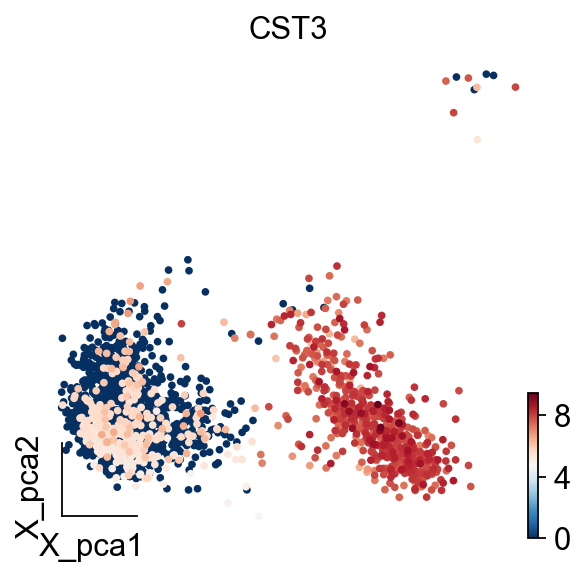

In [9]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']
ov.pl.embedding(adata,
                  basis='X_pca',
                  color='CST3',
                  frameon='small')

## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [10]:
%%time
ov.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
CPU times: user 5.49 s, sys: 44.2 ms, total: 5.53 s
Wall time: 5.11 s


You also can use `umap` to visualize the neighborhood graph

In [11]:
%%time
ov.pp.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
CPU times: user 3.59 s, sys: 682 ms, total: 4.27 s
Wall time: 3.12 s


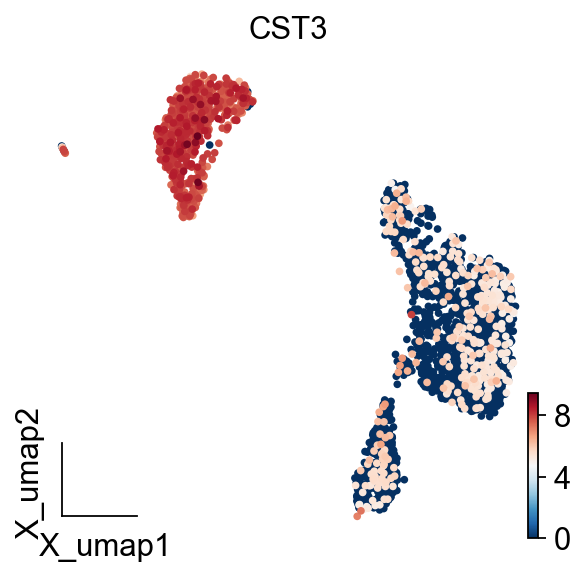

In [12]:
ov.pl.embedding(adata,
                basis='X_umap',
                color='CST3',
                frameon='small')

To visualize the PCA’s embeddings, we use the `pymde` package wrapper in omicverse. This is an alternative to UMAP that is GPU-accelerated.

In [13]:
ov.pp.mde(adata,embedding_dim=2,n_neighbors=15, basis='X_mde',
          n_pcs=50, use_rep='scaled|original|X_pca',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsm['X_mde']`, MDE coordinates
    `.obsp['neighbors_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_connectivities']`, weighted adjacency matrix (0:00:01)


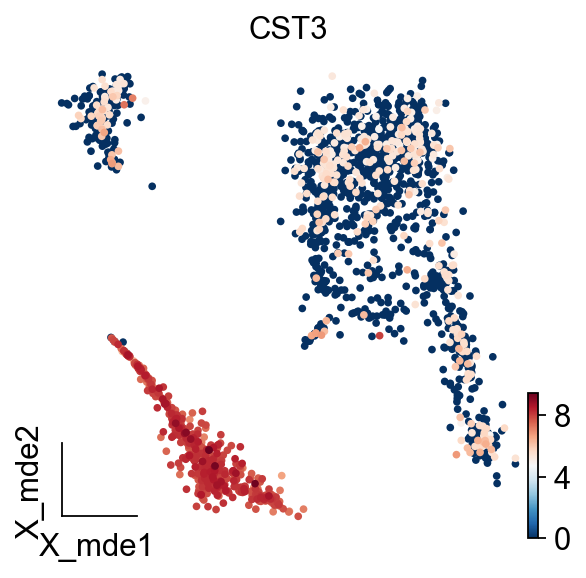

In [14]:
ov.pl.embedding(adata,
                basis='X_mde',
                color='CST3',
                frameon='small')

## Score cell cyle

In OmicVerse, we store both G1M/S and G2M genes into the function (both human and mouse), so you can run cell cycle analysis without having to manually enter cycle genes!

In [19]:
adata_raw=adata.raw.to_adata()
ov.pp.score_genes_cell_cycle(adata_raw,species='human')

calculating cell cycle phase
computing score 'S_score'
       'E2F8'],
      dtype='object')
    finished: added
    'S_score', score of gene set (adata.obs).
    728 total control genes are used. (0:00:00)
computing score 'G2M_score'
       'TTK', 'CDC25C', 'KIF2C', 'DLGAP5', 'CDCA2', 'CDCA8', 'HMMR', 'ANLN',
       'NEK2', 'GAS2L3', 'CENPA'],
      dtype='object')
    finished: added
    'G2M_score', score of gene set (adata.obs).
    769 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


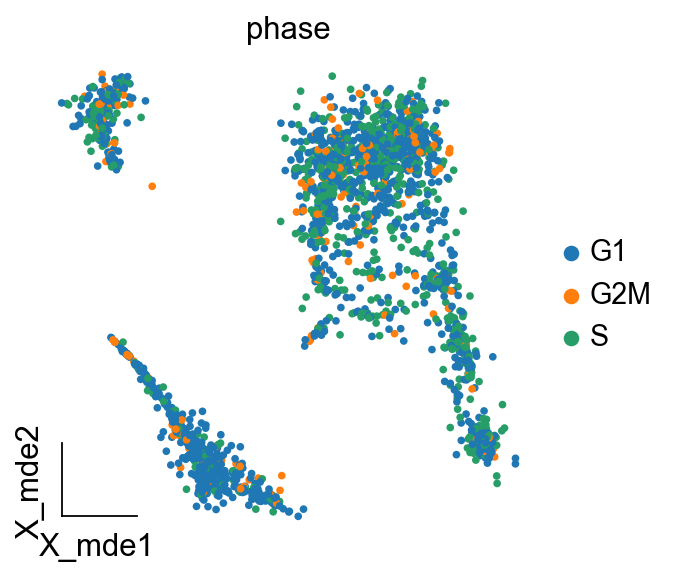

In [21]:
ov.pl.embedding(adata_raw,
                basis='X_mde',
                color='phase',
                frameon='small')

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [22]:
ov.pp.leiden(adata,resolution=1)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


We redesigned the visualisation of embedding to distinguish it from scanpy's embedding by adding the parameter `fraemon='small'`, which causes the axes to be scaled with the colourbar

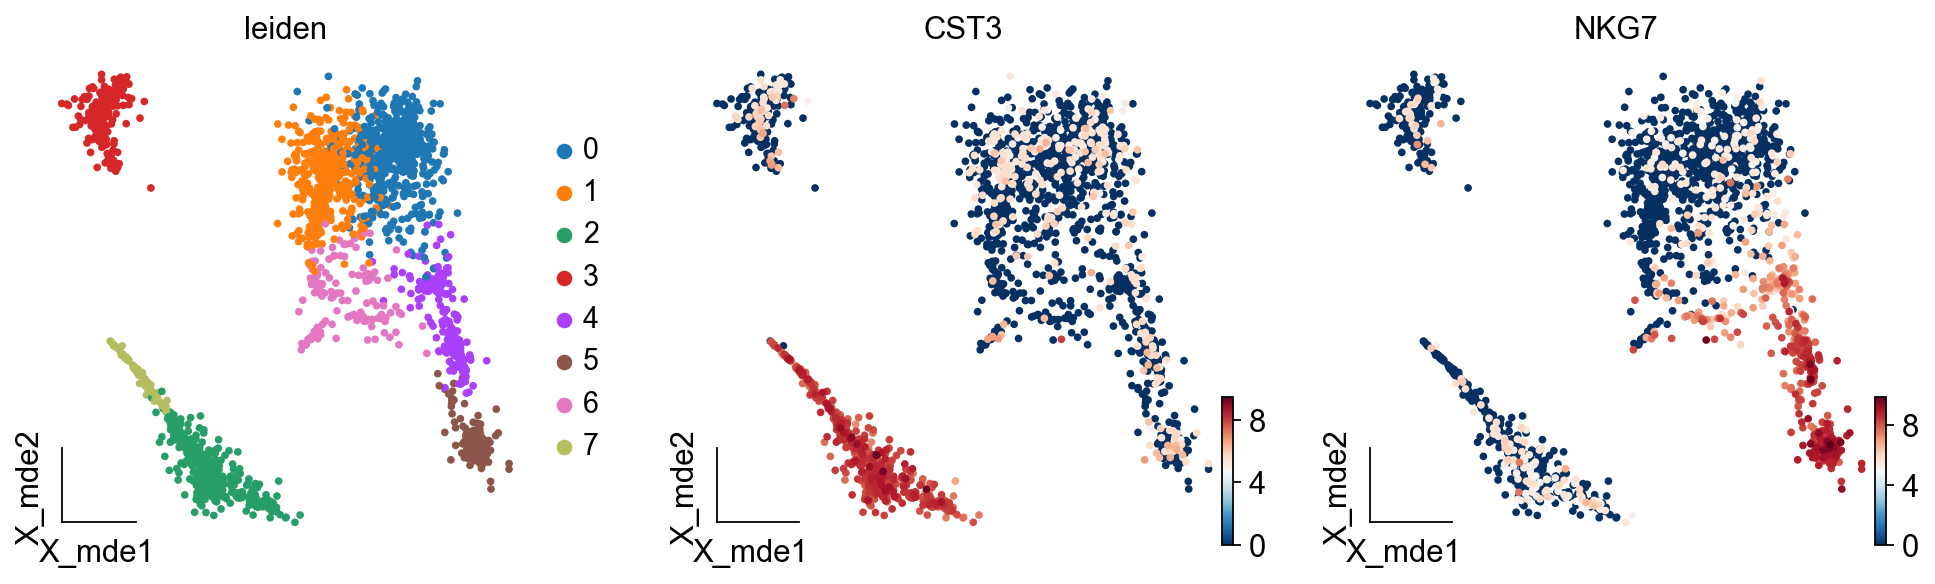

In [23]:
ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden', 'CST3', 'NKG7'],
                frameon='small')

We also provide a boundary visualisation function `ov.utils.plot_ConvexHull` to visualise specific clusters.

Arguments: 
- color: if None will use the color of clusters
- alpha: default is 0.2

leiden_colors


<AxesSubplot: title={'center': 'leiden'}, xlabel='X_mde1', ylabel='X_mde2'>

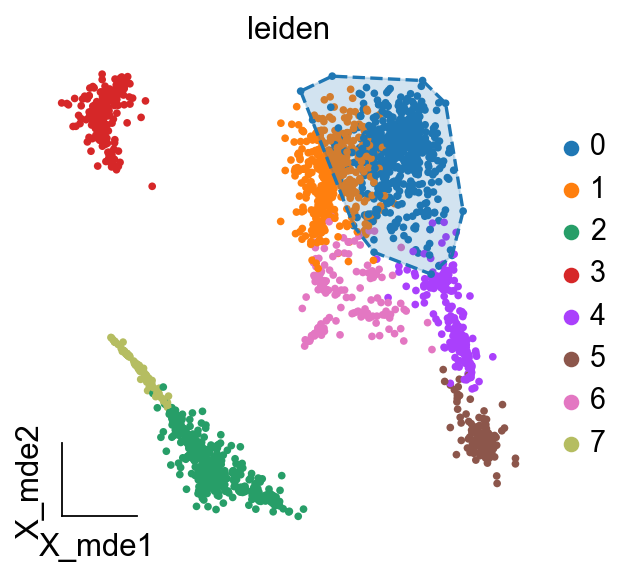

In [24]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots( figsize = (4,4))

ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden'],
                frameon='small',
                show=False,
                ax=ax)

ov.pl.ConvexHull(adata,
                basis='X_mde',
                cluster_key='leiden',
                hull_cluster='0',
                ax=ax)


If you have too many labels, e.g. too many cell types, and you are concerned about cell overlap, then consider trying the `ov.utils.gen_mpl_labels` function, which improves text overlap.
In addition, we make use of the `patheffects` function, which makes our text have outlines

- adjust_kwargs: it could be found in package `adjusttext`
- text_kwargs: it could be found in class `plt.texts`

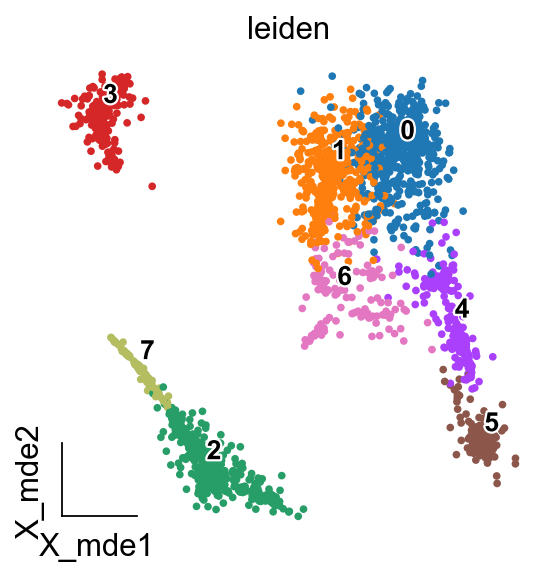

In [25]:
from matplotlib import patheffects
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))

ov.pl.embedding(adata,
                  basis='X_mde',
                  color=['leiden'],
                   show=False, legend_loc=None, add_outline=False, 
                   frameon='small',legend_fontoutline=2,ax=ax
                 )

ov.utils.gen_mpl_labels(
    adata,
    'leiden',
    exclude=("None",),  
    basis='X_mde',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize= 12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

In [26]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

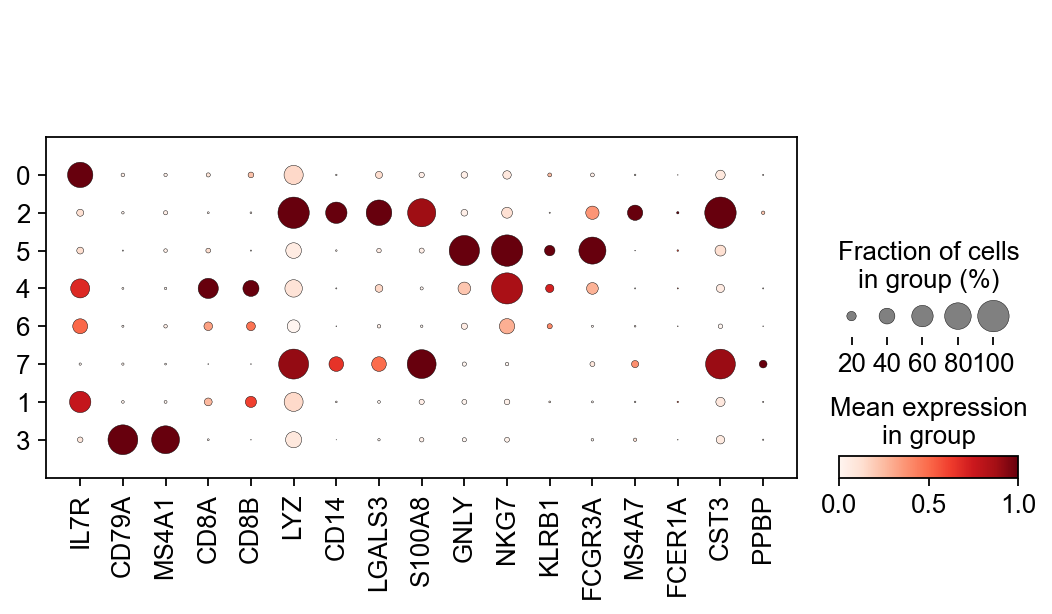

In [27]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',
             standard_scale='var');

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

Storing dendrogram info using `.uns['dendrogram_leiden']`
ranking genes
    finished: added to `.uns['leiden_ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


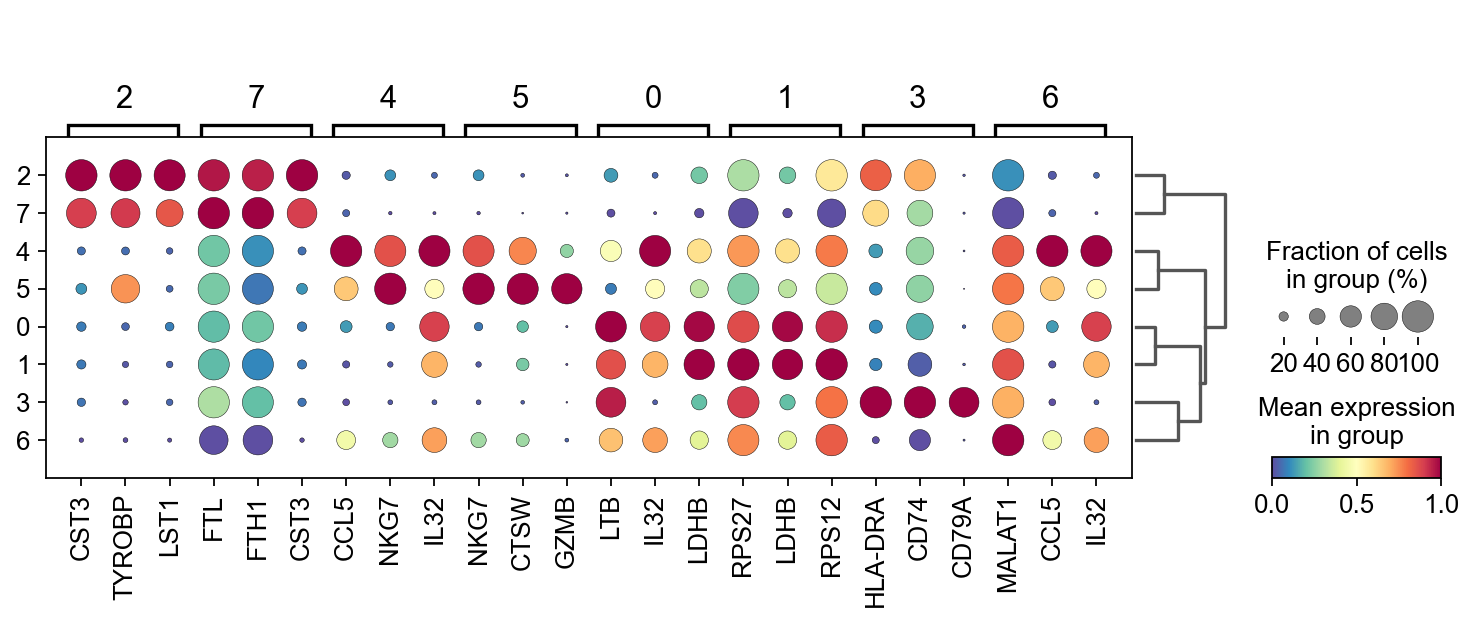

In [28]:
sc.tl.dendrogram(adata,'leiden',use_rep='scaled|original|X_pca')
sc.tl.rank_genes_groups(adata, 'leiden', use_rep='scaled|original|X_pca',
                        method='t-test',use_raw=False,key_added='leiden_ttest')
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_ttest',
                                standard_scale='var',n_genes=3)

cosg is also considered to be a better algorithm for finding marker genes. Here, omicverse provides the calculation of cosg

Paper: [Accurate and fast cell marker gene identification with COSG](https://academic.oup.com/bib/advance-article-abstract/doi/10.1093/bib/bbab579/6511197?redirectedFrom=fulltext)

Code: https://github.com/genecell/COSG


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
**finished identifying marker genes by COSG**


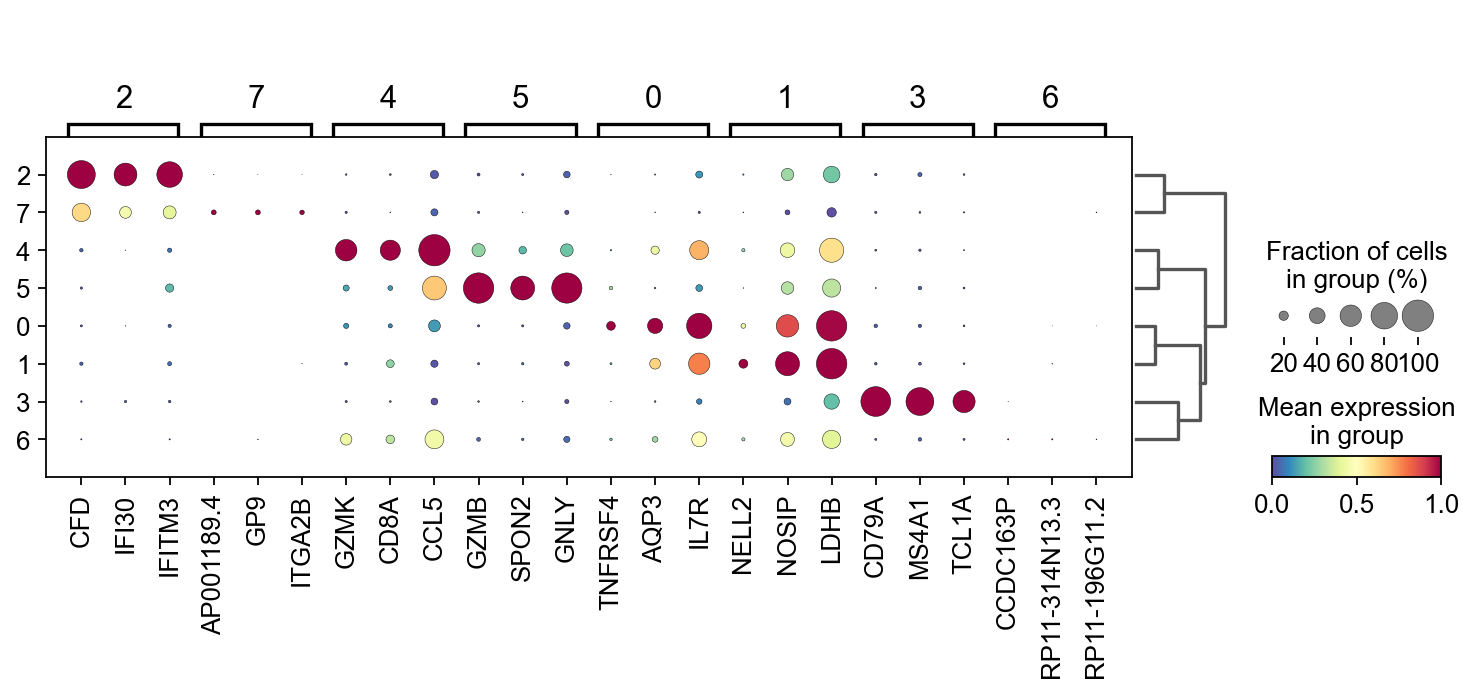

In [29]:
sc.tl.rank_genes_groups(adata, groupby='leiden', 
                        method='t-test',use_rep='scaled|original|X_pca',)
ov.single.cosg(adata, key_added='leiden_cosg', groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_cosg',
                                standard_scale='var',n_genes=3)

## Other plotting

Next, let's try another chart, which we call the Stacked Volcano Chart. We need to prepare two dictionaries, a `data_dict` and a `color_dict`, both of which have the same key requirements.

For `data_dict`. we require the contents within each key to be a DataFrame containing ['names','logfoldchanges','pvals_adj'], where names stands for gene names, logfoldchanges stands for differential expression multiplicity, pvals_adj stands for significance p-value


In [51]:
data_dict={}
for i in adata.obs['leiden'].cat.categories:
    data_dict[i]=sc.get.rank_genes_groups_df(adata, group=i, key='leiden_ttest',
                                            pval_cutoff=None,log2fc_min=None)

In [65]:
data_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [64]:
data_dict[i].head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,PF4,92.918243,17.017431,4.248822e-15,7.122920e-15
1,PPBP,85.572166,17.316359,6.224002e-15,1.041674e-14
2,SDPR,72.907913,16.093300,5.214614e-14,8.662149e-14
3,GNG11,72.813034,16.640303,5.858609e-14,9.723832e-14
4,GPX1,62.821903,9.493515,2.581554e-24,4.875457e-24


For `color_dict`, we require that the colour to be displayed for the current key is stored within each key.`

In [63]:
type_color_dict=dict(zip(adata.obs['leiden'].cat.categories,
                         adata.uns['leiden_colors']))
type_color_dict

{'0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#279e68',
 '3': '#d62728',
 '4': '#aa40fc',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#b5bd61',
 '8': '#17becf',
 '9': '#aec7e8',
 '10': '#ffbb78'}

There are a number of parameters available here for us to customise the settings. Note that when drawing stacking_vol with omicverse version less than 1.4.13, there is a bug that the vertical coordinate is constant at [-15,15], so we have added some code in this tutorial for visualisation.

- data_dict: dict, in each key, there is a dataframe with columns of ['logfoldchanges','pvals_adj','names']
- color_dict: dict, in each key, there is a color for each omic
- pval_threshold: float, pvalue threshold for significant genes
- log2fc_threshold: float, log2fc threshold for significant genes
- figsize: tuple, figure size
- sig_color: str, color for significant genes
- normal_color: str, color for non-significant genes
- plot_genes_num: int, number of genes to plot
- plot_genes_fontsize: int, fontsize for gene names
- plot_genes_weight: str, weight for gene names

0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22


Text(0.5, 0.98, 'Stacking_vol')

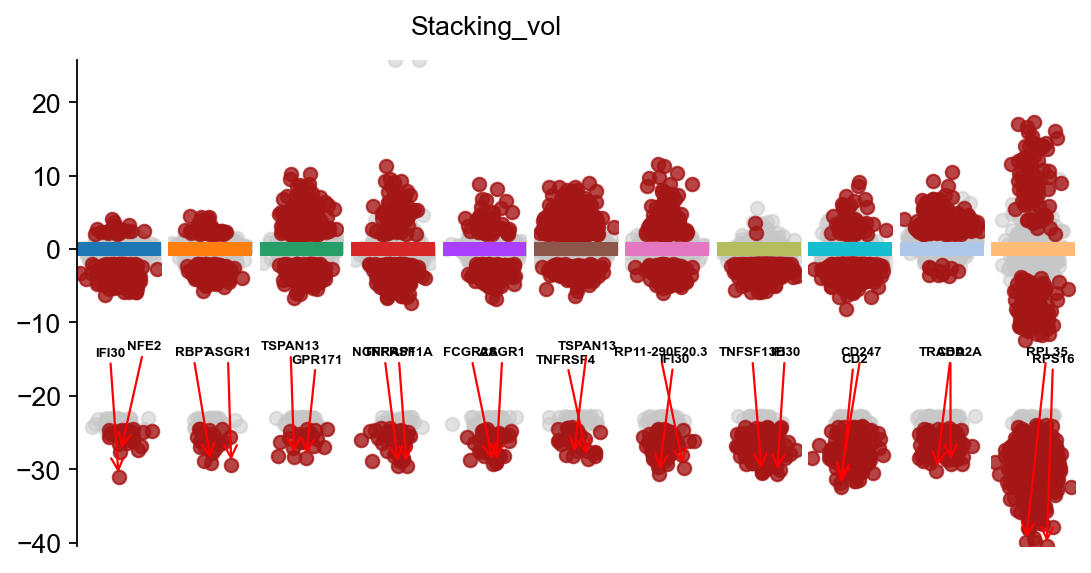

In [62]:
fig,axes=ov.utils.stacking_vol(data_dict,type_color_dict,
            pval_threshold=0.01,
            log2fc_threshold=2,
            figsize=(8,4),
            sig_color='#a51616',
            normal_color='#c7c7c7',
            plot_genes_num=2,
            plot_genes_fontsize=6,
            plot_genes_weight='bold',
            )

#The following code will be removed in future
y_min,y_max=0,0
for i in data_dict.keys():
    y_min=min(y_min,data_dict[i]['logfoldchanges'].min())
    y_max=max(y_max,data_dict[i]['logfoldchanges'].max())
for i in adata.obs['leiden'].cat.categories:
    axes[i].set_ylim(y_min,y_max)
plt.suptitle('Stacking_vol',fontsize=12)   